In [2]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import import_ipynb
from scipy.interpolate import PchipInterpolator
import seaborn as sns

In [4]:
def arm_detector(data, num_ventanas=25, b=0.6):
    n = len(data)
    x = np.arange(n)
    
    # Calcular el tamaño de cada ventana
    window_size = n // num_ventanas

    # Lista para almacenar los porcentajes de puntos dentro de las regiones
    porcentajes = []

    # Ajustar y graficar el ajuste lineal por cada ventana con las líneas paralelas
    for i in range(0, n, window_size):
        end = i + window_size
        if end > n:
            end = n
        
        x_window = x[i:end].reshape(-1, 1)
        y_window = data[i:end]
        
        # Crear y ajustar el modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(x_window, y_window)
        
        # Obtener la pendiente y la intersección de la recta ajustada
        pendiente = modelo.coef_[0]
        interseccion = modelo.intercept_
        
        # Predecir valores ajustados
        y_pred = modelo.predict(x_window)
                
        # Calcular las rectas paralelas desplazadas por 'b'
        y_paralela_superior = pendiente * x_window + (interseccion + b)
        y_paralela_inferior = pendiente * x_window + (interseccion - b)
                
        # Calcular el porcentaje de datos dentro de la región delimitada por las líneas paralelas
        dentro_region = np.sum((y_window >= y_paralela_inferior.flatten()) & (y_window <= y_paralela_superior.flatten()))
        fuera_region = len(y_window) - dentro_region
        
        # Calcular el porcentaje de datos dentro de la región respecto a los datos fuera de la región
        porcentaje = (dentro_region * 100)/(dentro_region + fuera_region)
        porcentajes.append(porcentaje)

    def indice_mayor_90(arr):
        n = len(arr)
    
        # Revisar cada índice para encontrar el primero que cumpla la condición
        for i in range(n):
            if np.all(arr[i:] > 80) and len(arr[i:]) > 4:
                return i
        # Si no hay tal índice, regresar el último índice
        return n - 1
    
    indice = indice_mayor_90(np.array(porcentajes))*window_size
    return indice

def J_univariante(X, tau, corte):
    # Define una función para calcular la distancia euclidiana entre dos puntos.
    def distancia(p1, p2):
        return np.linalg.norm(np.array(p2) - np.array(p1))

    # Crea dos subconjuntos de datos con un desfase de `tau`.
    x1 = X[tau:]
    y1 = X[:-tau]

    # Calcula las fases (ángulos) del espectro de Fourier de los subconjuntos.
    ff1 = np.angle(np.fft.rfft(x1))
    ff2 = np.angle(np.fft.rfft(y1))

    # Si se aplica un corte, se detectan puntos de transición en ambas señales.
    if corte:
        transition_point1 = arm_detector(ff1)  # Detecta la transición en `ff1`.
        transition_point2 = arm_detector(ff2)  # Detecta la transición en `ff2`.

        # Si los puntos de transición difieren, se usa el menor de los dos.
        if transition_point1 != transition_point2:
            transition_point1 = transition_point2 = min(transition_point1, transition_point2)

        # Recorta los datos hasta el punto de transición detectado.
        ff2 = ff2[:transition_point2]
        ff1 = ff1[:transition_point1]

    # Inicializa una lista para almacenar los vectores desplazados.
    vectores = []
    for i in range(len(ff1) - 1):
        # Define los puntos actuales y siguientes en el espacio de fases.
        p1 = [ff1[i], ff2[i]]
        p2 = [ff1[i + 1], ff2[i + 1]]

        # Genera todas las combinaciones posibles de desplazamientos considerando periodicidad.
        cuadrante = [
            [p2[0] - p1[0], p2[1] - p1[1]],
            [p2[0] - p1[0], p2[1] + 2 * np.pi - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] + 2 * np.pi - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] - p1[1]],
            [p2[0] + 2 * np.pi - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] - 2 * np.pi - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] - p1[1]],
            [p2[0] - 2 * np.pi - p1[0], p2[1] + 2 * np.pi - p1[1]],
        ]

        # Calcula la distancia de `p1` a cada posible `p2` desplazado.
        distancia1 = [distancia(p1, c) for c in cuadrante]

        # Selecciona el `p2` desplazado más cercano a `p1`.
        p2 = cuadrante[np.argmin(distancia1)]

        # Almacena el vector resultante entre `p1` y el `p2` más cercano.
        vectores.append([p2[0] - p1[0], p2[1] - p1[1]])

    # Inicializa una lista para almacenar los ángulos entre vectores consecutivos.
    angulos = []
    for i in range(len(vectores) - 1):
        v1 = vectores[i]
        v2 = vectores[i + 1]

        # Normaliza los vectores para calcular ángulos.
        v1_norm = v1 / np.linalg.norm(v1) if np.linalg.norm(v1) != 0 else v1
        v2_norm = v2 / np.linalg.norm(v2) if np.linalg.norm(v2) != 0 else v2

        # Calcula el ángulo entre los vectores usando el producto punto.
        angulo = np.arccos(np.clip(np.dot(v1_norm, v2_norm), -1.0, 1.0))

        # Calcula el producto cruzado para determinar la dirección del ángulo.
        cruz = v1[0] * v2[1] - v1[1] * v2[0]
        if cruz > 0:
            angulo = np.pi - angulo
        elif cruz == 0 and angulo < 0:
            angulo = np.pi
        elif cruz < 0:
            angulo += np.pi

        # Almacena el ángulo calculado.
        angulos.append(angulo)

    # Calcula la media de las exponenciales de los ángulos para estimar la uniformidad.
    e = [np.exp(ang * 1j) for ang in angulos]
    e1 = np.sum(e) / len(angulos)

    # Calcula `J`.
    J = 1.0 - np.abs(e1.real)
    return J


In [5]:
def interpolador(subject, method, size):
    """
    Interpola datos de entrada utilizando un método especificado y genera un conjunto más denso de puntos.

    Parámetros:
    -----------
    - subject: array-like
        Datos originales a interpolar (puede ser un array o una serie de pandas).
    - method: str
        Método de interpolación a usar: 'lineal' para interpolación lineal o 'herm' para interpolación cúbica de Hermite.
    - size: int
        Factor para aumentar la cantidad de puntos entre los datos originales.

    Retorna:
    --------
    - x_new: ndarray
        Nuevos puntos en el eje x, equidistantes entre los puntos originales.
    - data_interp: ndarray
        Datos interpolados correspondientes a los puntos en `x_new`.
    """
    
    # Si 'subject' es un DataFrame, convierte los datos a un array (línea comentada para contexto).
    # data = np.array([int(line.strip()) for line in subject.to_numpy()])
    
    data = subject  # Usa directamente el array de entrada como los datos a interpolar.
    
    # Crea un arreglo con índices originales (eje x).
    x = np.arange(len(data))
    
    # Genera un nuevo eje x con puntos equidistantes, incrementando la resolución por el factor `size`.
    x_new = np.linspace(0, len(data) - 1, size * (len(data) - 1) + len(data))
    
    # Realiza la interpolación según el método especificado.
    if method == 'lineal':
        # Interpolación lineal.
        data_interp = np.interp(x_new, x, data)
    elif method == 'herm':
        # Interpolación cúbica de Hermite usando el interpolador PCHIP.
        interpolator = PchipInterpolator(x, data)
        data_interp = interpolator(x_new)
    
    # Devuelve los nuevos puntos x y los datos interpolados.
    return x_new, data_interp

In [6]:
def interpolador_estocastico(s_0_discreto, n_steps):
    """
    Interpola un conjunto de datos discretos utilizando un proceso de puente de Brown (Brownian Bridge).
    Este proceso se utiliza para generar trayectorias estocásticas suavizadas entre puntos discretos.

    Parámetros:
    -----------
    - s_0_discreto: array-like
        Conjunto de datos discretos que se desea interpolar.
    - n_steps: int
        Número de pasos (intervalos) que se desea para cada trayecto de interpolación.

    Retorna:
    --------
    - t_list: ndarray
        Puntos de tiempo generados a lo largo de todo el proceso de interpolación.
    - X_list: ndarray
        Valores interpolados correspondientes a los puntos de tiempo.
    """

    # Inicializa las listas para almacenar los resultados.
    t_list, X_list = [], []

    # Define una función para crear el puente de Brown entre dos puntos.
    def brownian_bridge(t0, tT, x0, xT, n_steps=100):
        # Genera un conjunto de tiempos equidistantes entre t0 y tT.
        t = np.linspace(t0, tT, n_steps)
        
        # Genera un movimiento browniano con media cero.
        W = np.random.normal(0, np.sqrt(t[1] - t[0]), size=n_steps-1)
        W = np.insert(np.cumsum(W), 0, 0)  # Inserta W(0) = 0 y realiza la suma acumulativa
        
        # Interpola el puente de Brown, ajustando para que comience en x0 y termine en xT.
        X = x0 + (t - t0) / (tT - t0) * (xT - x0) + W - (t - t0) / (tT - t0) * W[-1]
        
        # Devuelve los tiempos y los valores del proceso.
        return t, X

    # Itera sobre los puntos discretos en s_0_discreto para aplicar el puente de Brown entre puntos consecutivos.
    for i in range(len(s_0_discreto) - 1):
        t0 = i  # El tiempo inicial es el índice actual.
        tT = i + 1  # El tiempo final es el siguiente índice.
        x0 = s_0_discreto[i]  # El valor inicial es el valor en s_0_discreto[i].
        xT = s_0_discreto[i + 1]  # El valor final es el valor en s_0_discreto[i+1].
        
        # Llama a la función brownian_bridge para interpolar entre t0 y tT.
        t, X = brownian_bridge(t0, tT, x0, xT, n_steps + 2)
        
        # Si es el primer intervalo, agrega los valores completos.
        if i == 0:
            t_list = np.concatenate((t_list, t[:]))
            X_list = np.concatenate((X_list, X[:]))
        else:
            # Si no es el primer intervalo, evita duplicar el primer punto de cada intervalo.
            t_list = np.concatenate((t_list, t[1:]))
            X_list = np.concatenate((X_list, X[1:]))

    # Devuelve los puntos de tiempo y los valores interpolados generados.
    return t_list, X_list


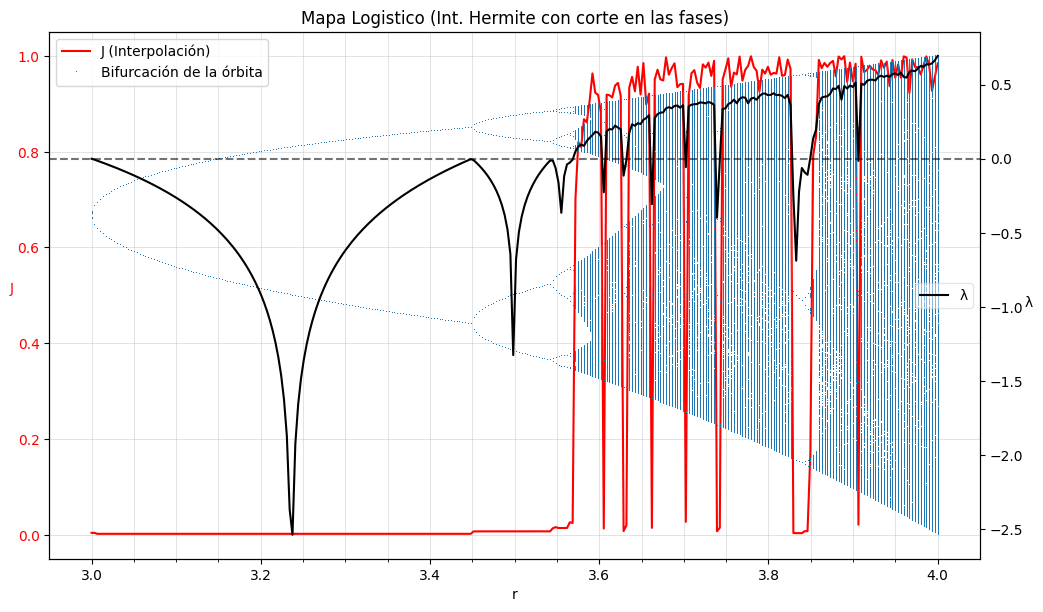

Correlación de Spearman: 1.0


In [11]:
"""interpolacion despues de dinamica simbolica"""


def logistic_map(r, x):
    return r * x * (1 - x)


def generar_uniforme_centrada(n, varianza):
    # Calcular el límite superior e inferior de la distribución uniforme
    limite = np.sqrt(varianza)
    # Generar n números aleatorios con distribución uniforme entre -limite y limite
    return np.random.uniform(-limite, limite, n)


"""Lyapunov para el mapa logístico"""
def lyapunov_exponent_from_orbit(orbit, r):
    lyapunov_sum = 0

    for x in orbit:
        # Derivada de la función logística
        derivative = abs(r * (1 - 2 * x))
        if derivative == 0:
            lyapunov_sum += 0
        else:
            lyapunov_sum += np.log(derivative)

    # Calcular el exponente de Lyapunov
    lyapunov_exponent = lyapunov_sum / len(orbit)
    return lyapunov_exponent






def plot_orbit_diagram(discreto,interpolacion, size, graficar, r_min = 3.0, r_max = 4.0, num_points_per_r=300,
 num_iterations_discard=1000, num_iterations_display=2000):

    if interpolacion == "si":
        print("Interpolación")

    r_values = []
    orbit_values = []
    
    for r in np.linspace(r_min, r_max, num_points_per_r):
        
        x = 0.6
        for _ in range(num_iterations_discard): # Converger
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 0.000001)[0]
        
        for _ in range(num_iterations_display):
            # x = np.clip(x, 0.0, 1.0)
            x = logistic_map(r, x) #+ generar_uniforme_centrada(1, 0.000001)[0]
            r_values.append(r)
            orbit_values.append(x)
        
    #A partir de aqui, orbita continua de logistica completada
        
    a = 0
    J_values=[]
    J_index=[]
    lyapunov_values = []
    
    r_values_interp = []
    orbit_values_interp = np.array([])

    for i in range(0, len(r_values) - 1):
        if r_values[i] != r_values[i+1]:
            r_single_orbit = orbit_values[a:i+1]
            a = i+1
            
            if interpolacion == 'si':
                x = np.arange(len(r_single_orbit))
                x_new, data_interp = interpolador(r_single_orbit, 'herm', 15)
                # data_interp = interpolador_estocastico(data_interp, 3)
                # data_interp = r_single_orbit
                # data_interp = data_interp + generar_uniforme_centrada(len(data_interp),1e-6)
                r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
                orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))

                r_single_orbit = data_interp


            lyapunov = lyapunov_exponent_from_orbit(r_single_orbit, r_values[i])
            lyapunov_values.append(lyapunov)
            J = J_univariante(r_single_orbit, 1, False)
            J_values.append(J)
            J_index.append(r_values[i])
    
    #ultimo valor de r
    lyapunov = lyapunov_exponent_from_orbit(orbit_values[a:], r_values[len(r_values) - 1])  
    lyapunov_values.append(lyapunov)
    r_single_orbit = orbit_values[a:]
    if interpolacion == 'si':
        x = np.arange(len(orbit_values[a:]))
        x_new, data_interp = interpolador(orbit_values[a:], 'herm', 15)
        # data_interp = interpolador_estocastico(data_interp, 3)
        # data_interp = orbit_values[a:]
        # data_interp = data_interp + generar_uniforme_centrada(len(data_interp), 1e-6)
        r_values_interp = r_values_interp + [r_values[i]]*len(data_interp)
        orbit_values_interp = np.concatenate((orbit_values_interp, data_interp))
        r_single_orbit = data_interp
    
    J = J_univariante(r_single_orbit, 1, False)
    J_values.append(J)
    J_index.append(r_values[len(r_values) - 1])

    #A partir de aqui, lyapunob y J fueron calculados

    with open('logistic_map/j_logistic_continuo.txt', 'r') as f:
        J_continuo = [float(line.strip()) for line in f]
    
    if graficar == True:
        fig, ax1 = plt.subplots(figsize=(10,6))
        
        if discreto == "no":
            color = "red"
        elif discreto == "si":
            color = "gray"
    
        ax1.plot(J_index, J_values, color=color, label='J (Interpolación)' , alpha = 1)
        if discreto == "si":
            ax1.plot(J_index, J_continuo, 'red',label='J (Original)', alpha = 0.3)
            if interpolacion == "si":
                ax1.plot(r_values_interp, orbit_values_interp, ',', label=f'Bifuración de la órbita (+ interpolación de 15 pts)', alpha=0.5)
            else: 
                ax1.plot(r_values, orbit_values, ',', label='Bifuración de la órbita', alpha=1)
        if discreto == "no":
            ax1.plot(r_values, orbit_values, ',', label='Bifurcación de la órbita', alpha=1)
        ax1.set_xlabel('r')
        ax1.set_ylabel('J', color='r', rotation = 360)
        ax1.tick_params(axis='y', labelcolor='r')
        # ax1.set_ylim(0,1)
        ax1.legend(loc = 'upper left')
        ax1.grid()
    
        
        fig.tight_layout()  
        major_ticks_x = np.linspace(3, 4, 6)  # 0.0, 0.2, ..., 1.0
        minor_ticks_x = np.linspace(3, 4, 21)  # Ticks secundarios

        major_ticks_y = np.linspace(0, 1, 6)  # -1, -0.5, 0, 0.5, 1.0
        minor_ticks_y = np.linspace(0, 1, 6)  # Ticks secundarios

        # Configurar los ticks del eje X
        plt.xticks(major_ticks_x)  # Solo etiquetar los ticks principales
        plt.gca().set_xticks(minor_ticks_x, minor=True)  # Agregar ticks menores sin etiquetas

        # Configurar los ticks del eje Y
        plt.yticks(major_ticks_y)  # Solo etiquetar los ticks principales
        plt.gca().set_yticks(minor_ticks_y, minor=True)  # Agregar ticks menores sin etiquetas

        # Activar la cuadrícula
        plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.5)  # Para ticks principales
        plt.grid(which='minor', linestyle='-', linewidth=0.5, alpha=0.5) 
        
        if discreto == "no":
            ax2 = ax1.twinx()
            ax2.axhline(y=0, color='black', linestyle='--', alpha =0.55)
            ax2.plot(J_index, lyapunov_values, 'black', label = 'λ')
            ax2.set_ylabel('λ', color='black', rotation = 360)
            ax2.tick_params(axis='y', labelcolor='black')
            ax2.legend(loc='center right',framealpha=0.5)
        # plt.title(f'Logistic Map (Discret ={discreto}, interp= {interpolacion})')
        # plt.title(f'Mapa Logístico con discretización en el eje y ({num_partitions} Particiones)')
        plt.title(f'Mapa Logistico (Int. Hermite con corte en las fases)')
        plt.show()

    
    if interpolacion == 'no':
        return J_index, J_values, r_values, orbit_values, lyapunov_values
    else:
        return J_index, J_values, r_values_interp, orbit_values_interp, lyapunov_values 


with open('logistic_map/lyapunov_continuo.txt', 'r') as f:
        lyapunov_continuo = [float(line.strip()) for line in f]

with open('logistic_map/j_logistic_continuo.txt', 'r') as f:
        J_continuo = [float(line.strip()) for line in f]

J_index, J_values, r_values, orbit_values, lyapunov_values = plot_orbit_diagram("no","no", 20 ,True)
# J_index, J_values, r_values, orbit_values, lyapunov_values_continuo = plot_orbit_diagram(50,"no", "no", 20 ,True)


# Calcular correlación de Spearman
correlacion, p_valor = spearmanr(J_values, J_continuo)

print(f'Correlación de Spearman: {correlacion}')

# np.save('J_continuo_2_5.npy', np.array(J_values))